# Problem 2

## (a) 
### Hidden layer:

1D Input → use shallow network (1–2 hidden layers)

2D or more dimension input → may need deeper network

### Node number:

Smooth, simple function→ small width (16–32)

Oscillatory / curved function→ moderate width (32–64)

Very complex function → larger width or extra layer

For this question, I choose 1 hidden layer and 32 nodes

## (b)
### Hidden layers: 

use ReLU as a good first choice (remember, it's just a good default, not a mandatory one).

### Output layer:

Regression (predict a real number, e.g., stock price differences): use Linear output.

Regression (predict a non-negative number, e.g., heights): use ReLU output. A special case of this is - predicting values between 0 and 1, say Probabilities - use Sigmoid output.

Binary classification (yes/no): use Sigmoid output (one node).

Multi-class classification (one of many classes): use Softmax (not covered yet in class) - don’t use a single sigmoid for this.

### My answer:
Hidden layer: ReLU

output layer: Linear

## (c)



![Loss Function](loss_function.png)

based on this rule, I choose MSE

## (d)

## Import the data

In [36]:
import pandas as pd

In [37]:
df = pd.read_csv('hw7_data.csv')

## Split data into two columns 

In [38]:
x = df.iloc[:, 0].to_numpy()

In [39]:
y = df.iloc[:, 1].to_numpy()

## Nomralize the data

In [40]:
x_normalized = (x - x.mean()) / x.std()
y_normalized = (y - y.mean()) / y.std()

In [41]:
x_normalized.shape

(99,)

## Convert data into tensor

In [42]:
import torch

In [43]:
x_t = torch.tensor(x_normalized, dtype=torch.float32).view(-1, 1)
y_t = torch.tensor(y_normalized, dtype=torch.float32).view(-1, 1)

# Convert the normalized data into a 2-dimensional float tensor that the neural network can read and process.

## Dataset & Dataloader

In [44]:
from torch.utils.data import TensorDataset, DataLoader

In [45]:
dataset = TensorDataset(x_t, y_t)
# Combine input tensor (x_t) and target tensor (y_t) into a dataset
# Each sample becomes a pair: (x, y)


loader = DataLoader(dataset, batch_size=32, shuffle=True)
# shuffle the order of pairs of data in the dataset and then splist the dataset into mini-batches
# 99 data & 32 batch --> batch1 32 pairs of data, batch2 32 pairs of data
# batch3 32 pairs of data, batch4 3 pairs of data


# A small dataset generally means fewer than 10,000 samples, 
# while fewer than 1,000 samples is considered very small. 
# dataset with 99 samples is considered very small or tiny.
# For small datasets, it is recommended to use smaller batch sizes such as 8, 16, or 32.
# In general, smaller datasets prefer smaller batches, and larger datasets can handle larger batch sizes.

## Model

In [46]:
import torch.nn as nn

In [47]:
model = nn.Sequential(     # generate the NNs
    nn.Linear(1, 32),      # the first hidden layer with 32 neurons (you choose the num of neurons before)
    nn.ReLU(),             # activation function (activation functions introduce non-linearity into the model)
    nn.Linear(32, 1)       # the output layer 
)

## Loss & Optimizer

In [48]:
loss_fn = nn.MSELoss() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.5)

# There are many optimizers. You may want to learn how to choose the loss_f and optimizers

## Training Loop

For small datasets like yours (99 samples)

Try 200–1000 epochs

Small datasets often need more epochs because each epoch sees very little data

In [49]:
epochs = 500
for epoch in range(epochs):
    for x, y in loader:
        # Forward pass (model makes prediction)
        forw = model(x)

        # compute loss (measure prediction error)
        loss = loss_fn(forw, y)

        # Backward pass (compute gradients to know How much the loss will change if we change this weight)
        optimizer.zero_grad()
        loss.backward()

        # Update weights (Adjust weights to reduce loss actomatically)
        optimizer.step()

    if epoch % 50 == 0:
        print (f"Epoch {epoch}, Loss: {loss.item()}")

        # We print training information to monitor learning progress, detect problems,
        # and decide when to stop training.


Epoch 0, Loss: 61.183162689208984
Epoch 50, Loss: 0.9024189114570618
Epoch 100, Loss: 0.749538004398346
Epoch 150, Loss: 2.209596872329712
Epoch 200, Loss: 0.5551714897155762
Epoch 250, Loss: 0.581571102142334
Epoch 300, Loss: 0.909783124923706
Epoch 350, Loss: 0.2447718381881714
Epoch 400, Loss: 1.2332655191421509
Epoch 450, Loss: 1.24567449092865


# Evaluate the Model & Visualize the result

In [ ]:
# Step 1: Switch to evaluation mode
model.eval()    # Tells PyTorch we are no longer training.

In [51]:
import numpy as np

In [52]:
x_grid = np.linspace(0, 10, 400)                 # 400 points in [0,10]
xg_t = torch.tensor(x_grid, dtype=torch.float32).view(-1, 1)  # shape (400,1)

In [55]:
xg_in = (xg_t - x.mean()) / x.std()   # normalize grid the same way as trainig

In [56]:
with torch.no_grad():
    y_pred = model(xg_in)  # shape (400,1)

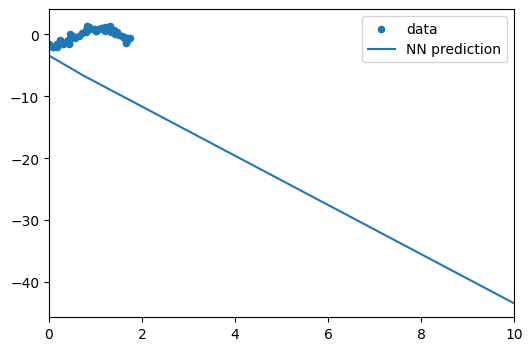

In [57]:
import matplotlib.pyplot as plt

y_pred_np = y_pred.squeeze().cpu().numpy()

plt.figure(figsize=(6,4))
plt.scatter(x_t.squeeze().cpu().numpy(), y_t.squeeze().cpu().numpy(), s=20, label="data")  # original points
plt.plot(x_grid, y_pred_np, label="NN prediction")  # prediction curve
plt.xlim(0, 10)
plt.legend()
plt.show()